In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import json

In [2]:
json_file = "logins.json"
df = pd.read_json(json_file)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# this method load json file in a dictionary form only
# with open(json_file, "r") as f:
#     data = json.load(f)
# data

In [4]:
type(df)

pandas.core.frame.DataFrame

In [5]:
df.columns

Index(['login_time'], dtype='object')

In [6]:
df['login_time'] = pd.to_datetime(df['login_time'])

In [7]:
df.isnull().sum()

login_time    0
dtype: int64

In [8]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
df = df.set_index('login_time')

In [10]:
df = df.resample('15min').size().reset_index(name = 'login_count')
df

,login_time,login_count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [11]:
df['login_time'] =  pd.to_datetime(df['login_time'])
df.set_index('login_time',inplace = True)

In [12]:
df.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [13]:
y = df['login_count']

In [14]:
type(y)

pandas.core.series.Series

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [16]:
y = y.asfreq('15min')

In [17]:
decomposition = seasonal_decompose(y, model = 'additive',period=96)

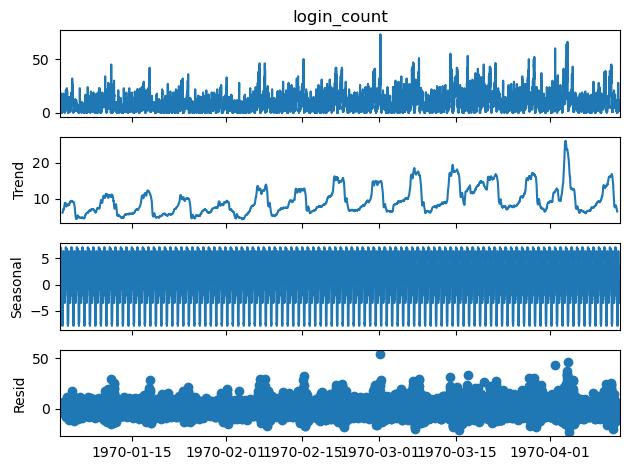

In [18]:
decomposition.plot()
plt.tight_layout()
plt.show()

### Conclusion from above graph:
The 15-minute login count series shows strong and stable daily seasonality, a gradually increasing trend indicating growing usage, and mostly stationary residual noise with occasional spikes. User demand is highly predictable at a daily level, with no major data quality issues observed apart from a few extreme but plausible outliers.

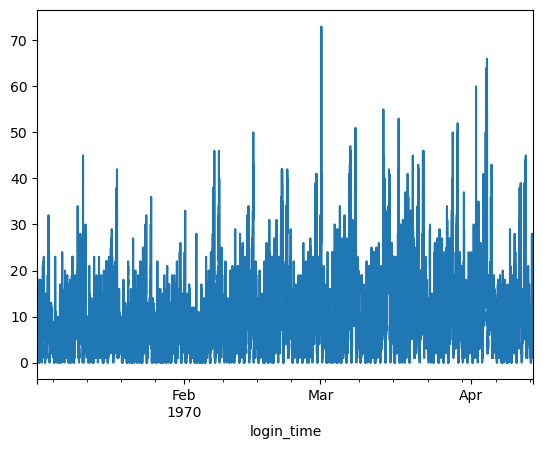

In [19]:
y.plot()
plt.show()

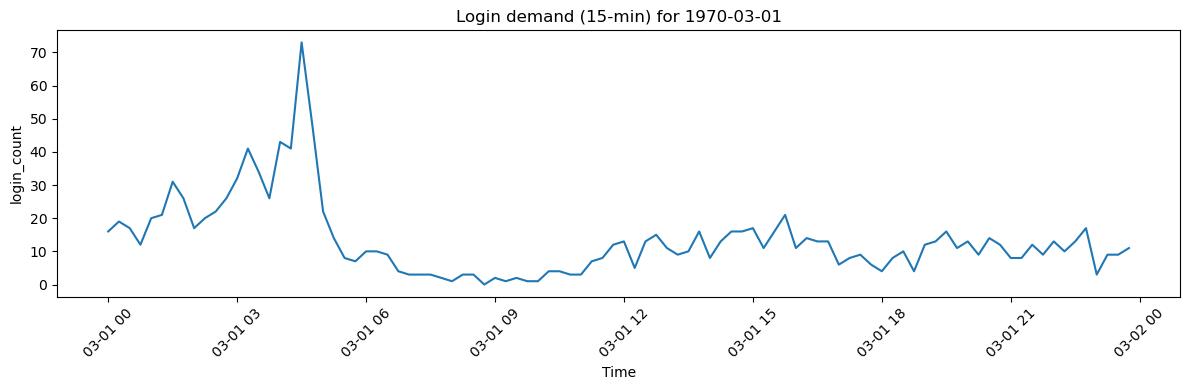

In [21]:
day = "1970-03-01"   # change this date

one_day = df.loc[day]   # picks that whole day (00:00 to 23:59)

plt.figure(figsize=(12,4))
plt.plot(one_day.index, one_day.values)
plt.title(f"Login demand (15-min) for {day}")
plt.xlabel("Time")
plt.ylabel("login_count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* The 15-minute trend shows a sharp early-morning spike followed by a steep drop and a gradual, steady increase in demand through the rest of the day.

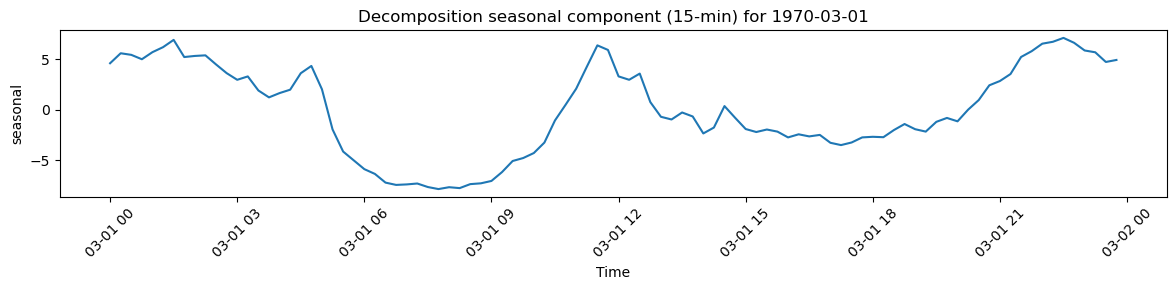

In [22]:
seasonal = decomposition.seasonal

# seasonal values for one chosen day
seasonal_one_day = seasonal.loc[day]

plt.figure(figsize=(12,3))
plt.plot(seasonal_one_day.index, seasonal_one_day.values)
plt.title(f"Decomposition seasonal component (15-min) for {day}")
plt.xlabel("Time")
plt.ylabel("seasonal")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Login demand is high around late night / early morning, then drops sharply in the early morning hours.
* It rises to a clear peak around 11 AM (midday peak).After that, usage declines and stays relatively steady through the afternoon and early evening.
* Forming an upward-U shaped pattern across the day. Demand then increases steadily again during late evening, reaching another peak around 11 PM.

In [23]:
from statsmodels.tsa.stattools import adfuller

# assuming you already created ts with columns: ['date','weekly_sales']
y = df['login_count'].dropna()

adf_stat, p_value, used_lags, n_obs, crit_values, icbest = adfuller(y, autolag='AIC')

print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Used lags:", used_lags)
print("Number of observations:", n_obs)
print("Critical Values:")
for k, v in crit_values.items():
    print(f"   {k}: {v}")

ADF Statistic: -10.337954309060441
p-value: 2.7323966542230642e-18
Used lags: 38
Number of observations: 9749
Critical Values:
   1%: -3.431020942932955
   5%: -2.8618365160244372
   10%: -2.5669278303551253


* p < 0.05 so we can  reject the null hypothesis of a unit root.

In [25]:
y_seasonal_diff = y.diff(96).dropna()  # 96 = 24 hours for 15-min data
# adfuller(y_seasonal_diff)